In [1]:
import numpy as N
import pandas
import tqdm
import matplotlib.pyplot as pyplot
import seaborn

seaborn.set_style('whitegrid')

import tqdm
import torch as T
import torch.distributions as TD
import torch.distributions.constraints as TDC
import torch.nn as TN
import torch.nn.functional as TNF
import pyro as P
import pyro.infer as PI
import pyro.optim as PO
import pyro.distributions as PD
import pyro.nn as PN
import pyro.poutine as PP

P.set_rng_seed(0)

In [2]:
import sys
sys.path.append('../..')
import igg
import model
import guide

In [3]:
# Data Generation
nData = 256
data = [model.generate() for _ in range(nData)]

elbo = PI.Trace_ELBO()

100%|██████████| 400/400 [05:21<00:00,  1.24it/s]


<AxesSubplot:xlabel='step', ylabel='loss'>

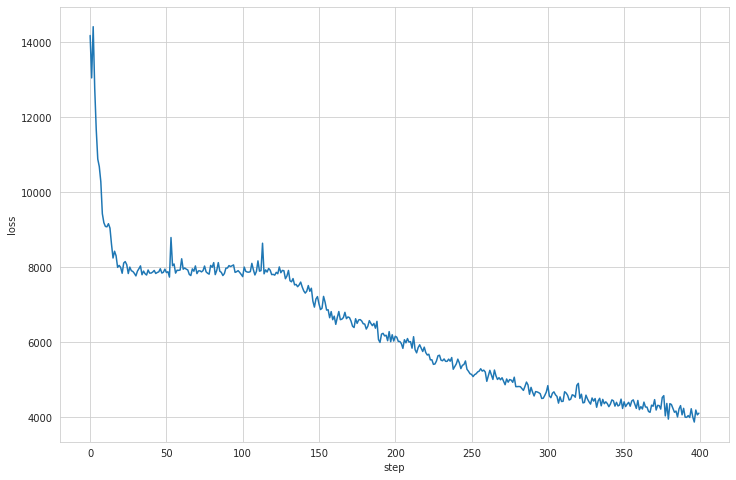

In [4]:
P.clear_param_store()
svi = PI.SVI(model=model.model,
            guide=guide.model,
            optim=PO.Adam({"lr": 0.001, "betas": (0.95,0.999)}),
            loss=elbo
            )
hist = pandas.DataFrame(columns=["step", "loss"])
for step in tqdm.trange(400):
    loss = sum([svi.step(*d) for d in data])
    hist = hist.append({
        "step": step,
        "loss": loss,
    }, ignore_index=True)

fig, ax = pyplot.subplots(figsize=(12,8))
seaborn.lineplot(x="step", y="loss", data=hist, ax=ax)

## Conditions

In [5]:
# an unconditioned version of the model
def model_uncond():
    n = P.sample("n", PD.Categorical(T.tensor([0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125])))
    for i in range(8):
        if i < n:
            P.sample(f"z{i}", PD.Normal(3.0, 1.0))
        else:
            P.sample(f"z{i}", PD.Normal(-3.0,1.0))

tracedModelUncond = PP.trace(model_uncond)

def trace_model_uncond():
    trace = tracedModelUncond.get_trace()
    n = trace.nodes['n']['value']
    obs = T.tensor([trace.nodes[f'z{i}']['value'] for i in range(8)])
    return n, obs

In [6]:
tracedGuide = PP.trace(guide.model)
def trace_guide(obs):
    trace = tracedGuide.get_trace(obs)
    n = trace.nodes['n']['value']
    return n

In [7]:
def single_sample():
    nModel,obs = trace_model_uncond()
    nGuide = trace_guide(obs)
    return int(nModel), int(nGuide)
def sample_model_guide(nSamples):
    samples = [single_sample() for _ in range(nSamples)]
    import collections
    occ = collections.Counter(samples)
    
    mat = N.zeros((8,8))
    for k,v in occ.items():
        mat[k] = v
    result = pandas.DataFrame(mat)
    result.columns.name = 'nGuide'
    result.index.name = 'nModel'
    
    # Calculate the indicators
    yTrue, yPred = zip(*samples)
    import sklearn.metrics as SM
    print(SM.classification_report(yTrue, yPred))
    return result


In [8]:
data = sample_model_guide(1000)
data

              precision    recall  f1-score   support

           0       0.61      0.89      0.73       132
           1       0.68      0.40      0.50       130
           2       0.94      0.82      0.87       114
           3       0.91      0.98      0.95       124
           4       0.93      0.93      0.93       124
           5       0.83      0.89      0.86       128
           6       0.88      0.66      0.76       125
           7       0.85      0.98      0.91       123

    accuracy                           0.82      1000
   macro avg       0.83      0.82      0.81      1000
weighted avg       0.83      0.82      0.81      1000



nGuide      0     1     2      3      4      5     6      7
nModel                                                     
0       118.0  13.0   1.0    0.0    0.0    0.0   0.0    0.0
1        73.0  52.0   5.0    0.0    0.0    0.0   0.0    0.0
2         2.0  12.0  93.0    7.0    0.0    0.0   0.0    0.0
3         0.0   0.0   0.0  122.0    2.0    0.0   0.0    0.0
4         0.0   0.0   0.0    5.0  115.0    3.0   1.0    0.0
5         0.0   0.0   0.0    0.0    6.0  114.0   8.0    0.0
6         0.0   0.0   0.0    0.0    0.0   20.0  83.0   22.0
7         0.0   0.0   0.0    0.0    0.0    0.0   2.0  121.0

<AxesSubplot:xlabel='nGuide', ylabel='nModel'>

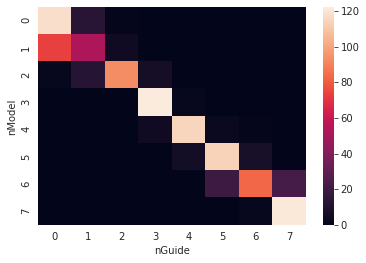

In [9]:
seaborn.heatmap(data)